In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from config.dataConfig import Config
from src.data import SimulationData
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader  

from torch_geometric.data import Data, Batch
from src.models import DeepONet
from src.dataset import MultiColDataset

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

seed = 42
set_seed(seed)

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/cebille/.venv/lib64/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cebille/.venv/lib64/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/cebille/.venv/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/home/cebille/.venv/lib64/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/home/cebille/.venv/lib64/python3.9/site-packages/traitlets/traitlets.py", line 649, in get
    value = self._validate(obj, default)
  File "/home/cebille/.venv/lib64

Random seed set as 42


In [2]:
import pickle
class SimulationDataLoader:
    def __init__(self):
        self.features = None

    def save_features(self, path):
        with open(path, "wb") as f:
            pickle.dump(self.features, f)

    def load_features(self, path):
        with open(path, "rb") as f:
            self.features = pickle.load(f)

In [3]:
data = SimulationDataLoader()
data.load_features('data/features2.pkl')

In [5]:
from src.dataset import compute_moment_of_inertia, compute_area_section, compute_local_slenderness_ratio

def get_trunk_input_rm(data: SimulationData, column_type: str, i: int, n_time_step=1):
    data_col = data.features[column_type]  # 214 time steps

    # Static geometric features
    d  = data_col["d"]
    t_w = data_col["t_w"]
    b_f = data_col["b_f"]
    t_f = data_col["t_f"]

    I = compute_moment_of_inertia(d, t_w, b_f, t_f)
    A = compute_area_section(d, t_w, b_f, t_f)
    lsr = compute_local_slenderness_ratio(8000, d, t_w, b_f, t_f)

    # All displacements as array/list
    disp_all = data_col["displacements"]

    # Current and next displacement
    disp = disp_all[i]
    if i < len(disp_all) - 1:
        disp_next = disp_all[i + 1]
    else:
        disp_next = disp  # end of sequence
    delta_disp = disp_next - disp
    # --------------------------------------------------------------
    # Build sequence of n_time_step previous displacements
    # --------------------------------------------------------------
    disp_seq = []
    for k in range(n_time_step):
        idx = (i + 1) - (n_time_step - k)   # indexes from (i+1 - n) ... (i)
        if idx < 0:
            # Not enough history -> use displacement at i
            disp_seq.append(disp)
        else:
            disp_seq.append(disp_all[idx])

    #disp_seq.append(horizontal_disp_next)
    disp_seq = [disp, disp_next, delta_disp]
    #disp_seq.append(delta_disp)
    # Convert to numpy array
    disp_seq = np.array(disp_seq, dtype=np.float32)  # shape: (n_time_step,)

    # --------------------------------------------------------------
    # Build final feature vector
    # --------------------------------------------------------------
    # Static geometry + current disp + next disp + sequence history
    features = np.concatenate([
        np.array([d, t_w, b_f, t_f], dtype=np.float32),
        disp_seq.flatten()
    ], axis=0)
    return torch.tensor(features, dtype=torch.float32)

In [6]:
column_type = 'W16X100'
i = 0 
test = get_trunk_input_rm(data, column_type, i)

In [8]:
test.shape

torch.Size([13])

In [6]:
data.features.keys()

dict_keys(['W16X100', 'W16X26', 'W16X31', 'W16X36', 'W16X40', 'W16X45', 'W16X50', 'W16X57', 'W16X67', 'W16X77', 'W16X89', 'W18X106', 'W18X119', 'W18X130', 'W18X35', 'W18X40', 'W18X46', 'W18X50', 'W18X55', 'W18X60', 'W18X65', 'W18X71', 'W18X76', 'W18X86', 'W18X97', 'W21X101', 'W21X111', 'W21X122', 'W21X132', 'W21X44', 'W21X48', 'W21X50', 'W21X55', 'W21X57', 'W21X62', 'W21X68', 'W21X73', 'W21X83', 'W21X93', 'W24X103', 'W24X104', 'W24X117', 'W24X131', 'W24X146', 'W24X55', 'W24X62', 'W24X68', 'W24X76', 'W24X84', 'W24X94', 'W27X102', 'W27X114', 'W27X129', 'W27X146', 'W27X161', 'W27X84', 'W27X94', 'W30X108', 'W30X116', 'W30X124', 'W30X132', 'W30X148', 'W30X173', 'W30X90', 'W30X99', 'W33X118', 'W33X130', 'W33X141', 'W33X152', 'W33X169', 'W33X201', 'W36X135', 'W36X150', 'W36X160', 'W36X170', 'W36X182', 'W36X194', 'W36X210', 'W40X149', 'W40X167', 'W40X183', 'W40X211'])

In [27]:
from sklearn.preprocessing import StandardScaler
def moments_scaler(data): 
    moments = []
    for key in data.features:
        moments.append(data.features[key]["resisting_moments"])

    moments = np.concatenate(moments, axis=0)
    moments = np.array(moments).reshape(-1,1)

    scaler = StandardScaler()
    moments_scaled = scaler.fit_transform(moments)
    
    return scaler
    

In [22]:
moments = []
for key in data.features:
    moments.append(data.features[key]["resisting_moments"])

moments = np.concatenate(moments, axis=0)
moments = np.array(moments).reshape(-1,1)
print(moments.shape)

(13937, 1)


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
moments_scaled = scaler.fit_transform(moments)
print(moments_scaled.mean(axis=0))

[-8.15719579e-18]


In [40]:
max_moments = []
for key in data.features:
    max_moments.append(np.max(data.features[key]["resisting_moments"]))

#max_moments = np.concatenate(max_moments, axis=0)
#max_moments = np.array(max_moments).reshape(-1,1)
#print(max_moments.shape)

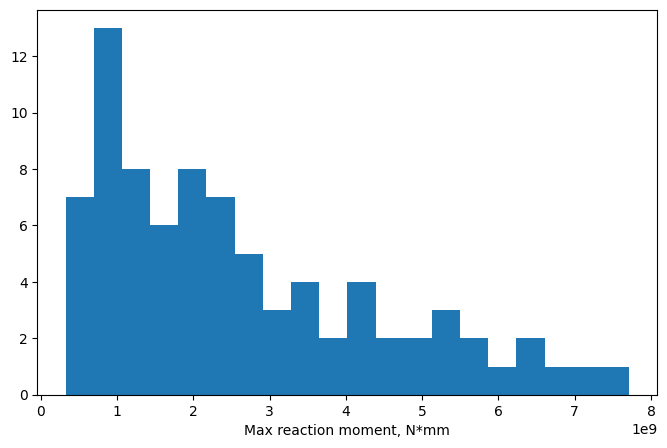

In [41]:
plt.figure(figsize=(8,5))
plt.hist(np.array(max_moments), bins=20)
plt.xlabel('Max reaction moment, N*mm')
plt.show()

In [7]:
data.features["W16X100"].keys()

dict_keys(['reserve_capacities', 'resisting_moments', 'horizontal_displacements', 'loading_protocols', 'coordinate_features', 'deviation_features', 'curvature_features', 'edge_index', 'edge_features', 'd', 't_w', 'b_f', 't_f', 'edge_norms', 'In-distribution test', 'Out-of-distribution test'])

In [9]:
import os
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from src.utils import compute_local_slenderness_ratio

from config.dataConfig import Config
from src.data import SimulationData
from src.dataset import MultiColDataset
from src.dataset import compute_normalization_stats, compute_graph_norm_stats
from src.utils import compute_mean_target, compute_std_target
from src.models import DeepONet
from collections import defaultdict

from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.explain import Explainer, GNNExplainer

def get_coords_timestep_i(data:SimulationData , column_type:str, i:int):
    data_col = data.features[column_type] # 214 timesteps
    node_coords = torch.tensor(data_col["coordinate_features"][i].reshape(-1, 3), dtype=torch.float32) # (70,3) timestep i

    return node_coords

import os
import torch
import matplotlib.pyplot as plt
import imageio
import numpy as np

def make_importance_gif_dynamic_graph(data, importance_list, col_type,
                                      gif_path="ReserveCapacityPrediction_DeepONet/figures/gifs/node_importance.gif",
                                      elev=20, azim=45):

    os.makedirs(os.path.dirname(gif_path), exist_ok=True)

    # Normalize global importance values for stable color scale
    all_imps = torch.stack(importance_list).cpu().numpy()
    importances = all_imps[-100:]
    global_min = importances.min()
    global_max = importances.max()

    # Get node coordinates for all timesteps
    all_pos = [get_coords_timestep_i(data, col_type, t) for t in range(len(importance_list))]
    all_pos = np.array(all_pos)
    
    posistions = all_pos[-100:]
    # Compute global axis limits
    x_min, y_min, z_min = posistions.min(axis=(0,1))
    x_max, y_max, z_max = posistions.max(axis=(0,1))

    frames = []

    for t, imp in enumerate(importances):
        pos = posistions[t]
        #imp = imp.detach().cpu().numpy()

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot with **fixed vmin/vmax** for colorbar
        sc = ax.scatter(
            pos[:, 0], pos[:, 1], pos[:, 2],
            c=imp,
            cmap="viridis",
            s=40,
            vmin=global_min,
            vmax=global_max
        )

        ax.set_title(f"Node Importance – t = {t}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Fixed camera view
        ax.view_init(elev=elev, azim=azim)

        # Set fixed axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

        # Colorbar with fixed scale
        cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
        cbar.set_label('Node Importance')

        # Optionally 5 evenly spaced ticks
        tick_labels = np.linspace(global_min, global_max, 5)
        cbar.set_ticks(tick_labels)
        cbar.set_ticklabels([f"{v:.4f}" for v in tick_labels])

        # Save frame
        frame_path = f"_tmp_frame_{t}.png"
        plt.savefig(frame_path, dpi=120)
        plt.close()

        frames.append(imageio.imread(frame_path))

    # Build GIF
    imageio.mimsave(gif_path, frames, fps=5)

    # Cleanup
    for t in range(len(frames)):
        os.remove(f"_tmp_frame_{t}.png")

    print(f"GIF saved to: {gif_path}")


from collections import defaultdict
from torch.utils.data import Subset
import shap  # Make sure shap is installed

# === 1. Load trained model ===
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = DeepONet(branch_in=7, trunk_in=4, hidden_dim=264, hidden_dim_trunk=264,
                 latent_dim=128, out_dim=2, dropout=0.2).to(device)
state_dict = torch.load("../best_deeponet_model.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()
print("✅ Model loaded and set to evaluation mode.")

# === 2. Prepare DataLoader ===
config = Config()
data = SimulationData(config)
data.load_features('data/features.pkl')

trunk_mean, trunk_std = compute_normalization_stats(data)
graph_mean, graph_std = compute_graph_norm_stats(data)
dataset = MultiColDataset(data, trunk_mean, trunk_std, graph_mean, graph_std)

trunk_mean, trunk_std = trunk_mean.to(device), trunk_std.to(device)
graph_mean, graph_std = graph_mean.to(device), graph_std.to(device)

# Separate by flags
test_set = "in_flag"
train_val_samples, test_samples = [], []
for i, sample in enumerate(dataset.samples):
    if sample[test_set]:
        test_samples.append(i)
    else:
        train_val_samples.append(i)

train_size = int(0.001 * len(train_val_samples))
train_samples = range(train_size)  # list/range of indices
train_dataset = Subset(dataset, train_samples)

loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

✅ Model loaded and set to evaluation mode.


/home/cebille/ReserveCapacityPrediction_DeepONet/src/dataset.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_trunk_inputs.append(torch.tensor(trunk_input, dtype=torch.float32))


In [10]:
class DeepONetSHAPWrapper(torch.nn.Module):
    """
    SHAP-compatible wrapper.
    Inputs:
        x_flat: flattened node features (1 x (N*F))
    Behavior:
        - reshapes node features back into graph.x
        - keeps graph structure and trunk input fixed
        - runs full DeepONet → scalar
    """
    def __init__(self, model, edge_index, edge_attr, trunk_input, output_component):
        super().__init__()
        self.model = model
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.trunk_input = trunk_input
        self.output_component = output_component
        self.num_nodes = edge_index.max().item() + 1

    def forward(self, x_flat):
        B = x_flat.size(0)
        num_features = x_flat.size(1) // self.num_nodes

        # reshape into graph node feature matrix
        x = x_flat.view(B, self.num_nodes, num_features)

        outputs = []
        for i in range(B):
            graph = Data(
                x=x[i],
                edge_index=self.edge_index,
                edge_attr=self.edge_attr
            )
            # Full DeepONet: branch(graph) + trunk(trunk_input)
            y = self.model(graph, self.trunk_input)
            y = y.view(-1)    
            y_scalar = y[self.output_component]
            outputs.append(y_scalar)

        return torch.stack(outputs, dim=0).squeeze(-1)  # shape (B,)


# ----------------------------------------------------------
# 4. Build SHAP background dataset
# ----------------------------------------------------------

background_x = []
max_background = 20

for graph, trunk_input, target, _, _, _ in loader:
    graph = graph.to(device)
    if len(background_x) < max_background:
        background_x.append(graph.x.view(1, -1))

background = torch.cat(background_x, dim=0)  # shape: [B, N*F]


In [13]:
# ----------------------------------------------------------
# 5. Compute SHAP per-sample
# ----------------------------------------------------------

importance_by_col = defaultdict(list)
shap_values_by_col = defaultdict(list)

col_filter = "W16X100"

# Use the first graph to instantiate the wrapper
ref_graph, ref_trunk_input, _, _, _, _ = next(iter(loader))
ref_graph, ref_trunk_input = ref_graph.to(device), ref_trunk_input.to(device)

shap_model = DeepONetSHAPWrapper(
    model=model,
    edge_index=ref_graph.edge_index,
    edge_attr=ref_graph.edge_attr,
    trunk_input=ref_trunk_input,
    output_component=0
).to(device)

explainer = shap.GradientExplainer(shap_model, background.to(device))
print("done1")

for graph, trunk_input, target, in_flag, out_flag, col in loader:
    print("done2")
    graph = graph.to(device)
    trunk_input = trunk_input.to(device)

    # Update wrapper trunk input for current sample
    shap_model.trunk_input = trunk_input

    x_flat = graph.x.view(1, -1).to(device)
    print(x_flat.shape)

    shap_vals = explainer.shap_values(x_flat)[0]       # numpy
    shap_vals = torch.tensor(shap_vals).view(graph.x.shape)

    # Node-level importance
    node_imp = shap_vals.abs().sum(dim=1)

    shap_values_by_col[col[0]].append(shap_vals.cpu())
    importance_by_col[col[0]].append(node_imp.cpu())

print("importance calculation done.")
print(importance_by_col[col[0]][0])
print(shap_values_by_col[col[0]][0])

done1
done2
torch.Size([1, 490])


KeyboardInterrupt: 